# ML CUP 2022 #

## Random Search with Keras #


This notebook creates a neural network using the framework Keras to generalize the problem of the ML cup 2022. it searches the best combination of hyperparameters performing a nested random search over a given range of values. Below there is a brief account about the implementation of the neural network.

hyperparameters considered for the random search:

1. Learning rate
2. The coefficient for momentum
3. Number of units of the hidden layers
4. the lambda coefficient for lasso regularisation (L1)
5. Number of hidden layers (1 against 2)

Model created using early stopping.\
Model selection performed using a cross validation.\
The model assessment phase in not included in this notebook



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras_tuner as kt
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import regularizers
from keras import metrics

from sklearn.utils import shuffle
from sklearn import model_selection

from operator import itemgetter

import keras.backend as K

2022-12-13 23:13:45.215154: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-13 23:13:45.323658: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-12-13 23:13:45.323674: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-12-13 23:13:45.813823: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-

Loading data for the ML cup 2022

In [2]:
# set a fixed seed
seed = 1
np.random.seed(seed)
tf.random.set_seed(seed)

In [3]:
colnames = ['id', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a7', 'a8', 'a9', 'target1', 'target2']
mlcup_tr = pd.read_csv("./dataset/ml_cup22/ML-CUP22-TR.csv", sep = ",", names=colnames)
mlcup_tr = mlcup_tr.iloc[1:, :]
mlcup_tr = mlcup_tr.drop('id', axis=1)

In [4]:
x_mlcup_tr = mlcup_tr.iloc[:, 0:9].values
y_mlcup_tr = mlcup_tr.iloc[:, 9:11].values

Below there is the target's shape before the normalization

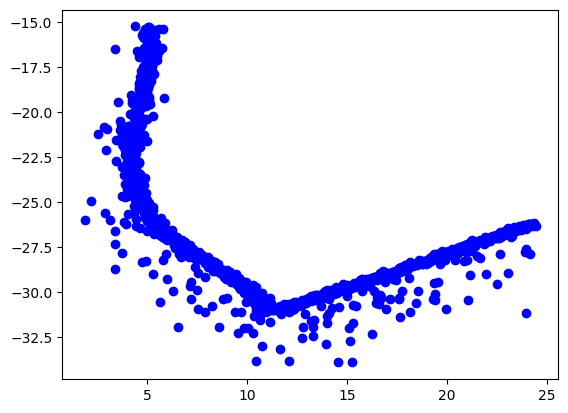

In [5]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], color="blue")
plt.show()

## Data Normalization ##

Let's normalize our data performing a min-max normalization

In [6]:
x_cols = len(x_mlcup_tr[0])

max_col_value_x = [None]*x_cols
max_vl = None

min_col_value_x = [None]*x_cols
min_vl = None

for i in range(x_cols):
    col = x_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    x_mlcup_tr[:, i] = (x_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_x[i] = max_vl
    min_col_value_x[i] = min_vl
    
    
    
y_cols = len(y_mlcup_tr[0])

max_col_value_y = [None]*y_cols

min_col_value_y = [None]*y_cols

for i in range(y_cols):
    col = y_mlcup_tr[:, i]
    max_vl = np.amax(col)
    min_vl = np.amin(col)
    
    y_mlcup_tr[:, i] = (y_mlcup_tr[:, i] - min_vl) / (max_vl - min_vl)
    
    max_col_value_y[i] = max_vl
    min_col_value_y[i] = min_vl 

Below there is the target shape after the normalization

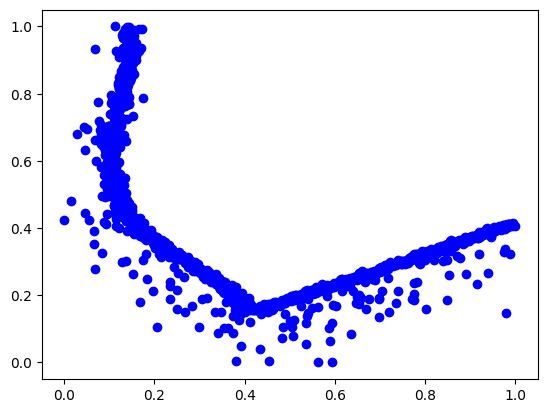

In [7]:
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], color="blue")
plt.show()

## Neural Network with Random Search ##

Below we extended the RandomSearch class of the keras_tuner library to perform a cross validation during the phase of model selection (which is not supported by the RandomSearch class).

In [8]:
class CrossValidationRandomSearch(kt.RandomSearch):

    
    cross_validation_partitions = -1
    
    
    def __init__(
        self,
        hypermodel=None,
        objective=None,
        max_trials=10,
        seed=None,
        hyperparameters=None,
        tune_new_entries=True,
        allow_new_entries=True,
        folds_number=1,
        **kwargs
    ):
        self.cross_validation_partitions = model_selection.KFold(folds_number)
        
        
        kt.RandomSearch.__init__(
            self,
            hypermodel=hypermodel,
            objective=objective,
            max_trials=max_trials,
            seed=seed,
            hyperparameters=hyperparameters,
            tune_new_entries=tune_new_entries,
            allow_new_entries=allow_new_entries,
            **kwargs
        )

        
    def run_trial(self, trial, x_train, y_train, *args, **kwargs):
    
        histories_cv = []
        histories_folds = []
        # build a different model for each fold of the cross validation
        for train_indices, test_indices in self.cross_validation_partitions.split(x_train):
            x_cv_train, x_cv_val = x_train[train_indices], x_train[test_indices]
            y_cv_train, y_cv_val = y_train[train_indices], y_train[test_indices]
            histories_folds = super(CrossValidationRandomSearch, self).run_trial(
                trial, x_cv_train, y_cv_train, validation_data=(x_cv_val, y_cv_val), *args, **kwargs
            )
            histories_cv.append(histories_folds)

            histories_folds = []
        # return the performance of each model
        return histories_cv

Now we are about to define the mean Euclidean distance to use it as metric for the model.

In [9]:
# This function computes the mean euclidean distance for Keras
def euclidean_distance(y_true, y_pred):
    """
    mean Euclidean distance error
    :param y_true: TensorFlow/Theano tensor
    :param y_pred: TensorFlow/Theano tensor of the same shape as y_true
    :return: float
    """
    return (K.sqrt(K.sum(K.square(y_pred - y_true), axis=-1))) 

Below we defined two functions; the first one is used to create a model given a combination of hyperparameters, while the second one select a random combination of hyperparameters in a given range

In [10]:
# instantiate a model given a specific combination of hyperparameters
def set_hyperparameters(units, lasso_lambda, learning_rate, momentum, double_layer, my_metric):
    model = Sequential()
    model.add(
        Dense(
            units=units,
            activity_regularizer=regularizers.L1(lasso_lambda),
            activation="relu",
        )
    )
    # if double_layer == True, a second layer for the NN is added
    if (double_layer):
        model.add(
            Dense(
                units=units,
                activity_regularizer=regularizers.L1(lasso_lambda),
                activation="relu"
            )
        )
    model.add(Dense(2, activation="linear", activity_regularizer=regularizers.L2(lasso_lambda)))

    
    # the optimizer is the stochastic gradient descent algorithm
    opt = optimizers.SGD(learning_rate=learning_rate, momentum=momentum)

    model.compile(
        optimizer=opt, loss="mean_squared_error", metrics=[my_metric]
    )
    
    return model

# extract a random combination of hyperparamaters
def build_regressor(hp, my_metric,min_units=30, max_units=50, min_lasso_lambda=0.00001, max_lasso_lambda=0.01, min_lr_rate=0.05, 
                max_lr_rate=0.15, min_mom=0.0, max_mom=0.8, linear_lr=False, linear_reg=False, double_layer=False):
    
    
    learning_rate_sampling = "log"
    if (linear_lr):
        learning_rate_sampling = "linear"
    
    lasso_lambda_sampling = "log"
    if(linear_reg):
        lasso_lambda_sampling = "linear"
    
    units_step = 1
    if (max_units - min_units > 5):
        units_step = 3
    
    # the variable 'units' represents the number of units of the hidden layer
    # by default this value is extracted between 2 and 11 (the user can specify a different interval)
    units = hp.Int("units", min_value=min_units, max_value=max_units, step=units_step)
    
    # the variable 'lasso_lambda' represents the lambda coefficient for Lasso regularization (L1)
    # by default this value is extracted between 0.0001 and 0.1 with a logarithmic probabilistic law
    # (the user can specify a different interval)
    lasso_lambda = hp.Float(
        "lasso_lambda", min_value=min_lasso_lambda, max_value=max_lasso_lambda, sampling=lasso_lambda_sampling
    )
    
    # the variable 'learning rate' represents the step used by the stochastic gradient descent algorithm
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    learning_rate = hp.Float(
        "learning_rate", min_value=min_lr_rate, max_value=max_lr_rate, sampling=learning_rate_sampling
    )
    
    # the variable 'momentum' represents the coefficient drawn for momentum
    # by default this value is extracted between 0.1 and 0.6 (the user can specify a different interval)
    momentum = hp.Float("momentum", min_value=min_mom, max_value=max_mom, sampling="linear")
    
    # Create the model with the set of hyperparameters drew
    model = set_hyperparameters(
        units=units, lasso_lambda=lasso_lambda, learning_rate=learning_rate, 
        momentum=momentum, double_layer=double_layer, my_metric=my_metric
    )
    return model

the function below was used to denormalize the targets predicted by the final model

In [11]:
def deNormalizer(pred_labels, max_col_value_y, min_col_value_y):
    
    y_cols = len(pred_labels[0])
    
    for i in range(y_cols):
        
        pred_labels[:, i] = pred_labels[:, i] * (max_col_value_y[i] - min_col_value_y[i]) + min_col_value_y[i]
    
    return pred_labels

compute the mean Euclidean error between the target and the predicted label

In [12]:
def compute_mean_euclidean_error(set1, set2):
    
    total_len = set1.shape[0]
    
    eu_dist = [None]*len(set1)
    
    for i in range(total_len):
        diff = set1[i] - set2[i]
        sum = 0
        for j in range(len(diff)):
            sum += math.pow(diff[j], 2)
        eu_dist[i] = math.sqrt(sum)
    
    sum = 0
    for i in range(len(eu_dist)):
        sum += eu_dist[i]
    
    final_vl = sum / len(eu_dist)
    return final_vl

Let's start searching randomly the best combination of hyperparameters using only one hidden layer.

In [13]:
br_l = lambda a : build_regressor(a, my_metric=euclidean_distance)

tuner = CrossValidationRandomSearch( 
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts 
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/first/par_hp",
    folds_number=3, # number of folds of the cross validation
    distribution_strategy=tf.distribute.MirroredStrategy()
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


2022-12-13 23:13:47.017017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-12-13 23:13:47.017040: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2022-12-13 23:13:47.017064: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (carlo-Aspire-A515-52G): /proc/driver/nvidia/version does not exist
2022-12-13 23:13:47.017339: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


print a brief description of the search space

In [14]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 3, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [15]:
tuner.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 02m 34s]
val_euclidean_distance: 0.08783734713991483

Best val_euclidean_distance So Far: 0.08469736700256665
Total elapsed time: 02h 14m 34s
INFO:tensorflow:Oracle triggered exit


In [16]:
best_hp = tuner.get_best_hyperparameters(3)

print("results of the first random search with a single hidden layer\n")
for i in range(len(best_hp)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp[i].get(h_param))
    print("")

results of the first random search with a single hidden layer

best hyperparameters n. 0
units 42
lasso_lambda 0.0030284296613009858
learning_rate 0.1358252210735858
momentum 0.5613835703312117

best hyperparameters n. 1
units 39
lasso_lambda 0.0005422922002994077
learning_rate 0.13981305060813434
momentum 0.509584565057199

best hyperparameters n. 2
units 48
lasso_lambda 0.002948938240962494
learning_rate 0.12915312470252838
momentum 0.7884944979137742



Brief description of the final neural network's structure

In [17]:
f_model = br_l(best_hp[0])
f_model.build(
input_shape=(None, 9))

f_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 42)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 86        
                                                                 
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


In [18]:
tuner.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/single_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0030284296613009858
learning_rate: 0.1358252210735858
momentum: 0.5613835703312117
Score: 0.08469736700256665
Trial summary
Hyperparameters:
units: 39
lasso_lambda: 0.0005422922002994077
learning_rate: 0.13981305060813434
momentum: 0.509584565057199
Score: 0.08500948051611583
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.002948938240962494
learning_rate: 0.12915312470252838
momentum: 0.7884944979137742
Score: 0.08521253739794095
Trial summary
Hyperparameters:
units: 36
lasso_lambda: 0.0020770341031481725
learning_rate: 0.09642757737024395
momentum: 0.6768603753119716
Score: 0.0852754736940066
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.002281653951895992
learning_rate: 0.08697680429159414
momentum: 0.3745525015495747
Score: 0.08534710854291916
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0

Now we have found a first best set of hyperparameters. At this point, we are ready to perform a second nested random search to explore the space around the best set of hyperparameters found.

In [19]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp[0].get(h_param[0])
lasso_lambda = best_hp[0].get(h_param[1])
learning_rate = best_hp[0].get(h_param[2])
momentum = best_hp[0].get(h_param[3])
double_layer = False

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance,
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, 
    linear_lr=True, linear_reg=True, double_layer=double_layer
)

tuner2 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/single_layer/nested/par_hp",
    folds_number=3, # number of folds of the cross validation
    distribution_strategy=tf.distribute.MirroredStrategy()
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Again, below there is a brief summary of the search space

In [20]:
tuner2.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 42, 'max_value': 42, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.0024227437290407884, 'conditions': [], 'min_value': 0.0024227437290407884, 'max_value': 0.0036341155935611827, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.10866017685886864, 'conditions': [], 'min_value': 0.10866017685886864, 'max_value': 0.16299026528830296, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.4491068562649693, 'conditions': [], 'min_value': 0.4491068562649693, 'max_value': 0.673660284397454, 'step': None, 'sampling': 'linear'}


On the cell below we started the second nested random search (with again only one hidden layer)

In [21]:
tuner2.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 02m 05s]
val_euclidean_distance: 0.08462620278199513

Best val_euclidean_distance So Far: 0.08360788722832997
Total elapsed time: 01h 42m 09s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search

In [22]:
best_hp2 = tuner2.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp2)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp2[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 42
lasso_lambda 0.0027084776623809296
learning_rate 0.15365229628761884
momentum 0.634926213174768

best hyperparameters n. 1
units 42
lasso_lambda 0.0034952216527680356
learning_rate 0.16128110345130298
momentum 0.48714887434761545

best hyperparameters n. 2
units 42
lasso_lambda 0.0027543452905927418
learning_rate 0.12376476790059147
momentum 0.6126970118276287



Brief description of the final neural network's structure

In [23]:
br_l2 = lambda a : build_regressor(a, my_metric=euclidean_distance)

f_model2 = br_l2(best_hp2[0])
f_model2.build(
input_shape=(None, 9))

f_model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 42)                420       
                                                                 
 dense_3 (Dense)             (None, 2)                 86        
                                                                 
Total params: 506
Trainable params: 506
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using only one hidden layer

In [24]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [25]:
n_trials = 10

models = [None]*n_trials

for i in range(n_trials):
    models[i] = br_l2(best_hp2[0])

n_epochs = 1000
hist = [None]*n_trials

for i in range(n_trials):
        hist[i] = models[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
30/30 [==============================] - 1s 6ms/step - loss: 0.0696 - euclidean_distance: 0.2699 - val_loss: 0.0289 - val_euclidean_distance: 0.1785
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0261 - euclidean_distance: 0.1683 - val_loss: 0.0223 - val_euclidean_distance: 0.1579
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0204 - euclidean_distance: 0.1472 - val_loss: 0.0177 - val_euclidean_distance: 0.1385
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0173 - euclidean_distance: 0.1331 - val_loss: 0.0154 - val_euclidean_distance: 0.1260
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0157 - euclidean_distance: 0.1244 - val_loss: 0.0146 - val_euclidean_distance: 0.1206
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.1170 - val_loss: 0.0140 - val_euclidean_distance: 0.1133
Epoch 7/1000
30/30 [========

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0877 - val_loss: 0.0085 - val_euclidean_distance: 0.0878
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0888 - val_loss: 0.0085 - val_euclidean_distance: 0.0895
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0883 - val_loss: 0.0085 - val_euclidean_distance: 0.0883
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0877 - val_loss: 0.0084 - val_euclidean_distance: 0.0875
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0872 - val_loss: 0.0087 - val_euclidean_distance: 0.0884
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0867 - val_loss: 0.0085 - val_euclidean_distance: 0.0882
Epoch 57/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0833 - val_loss: 0.0078 - val_euclidean_distance: 0.0852
Epoch 102/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0824 - val_loss: 0.0082 - val_euclidean_distance: 0.0868
Epoch 103/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0838 - val_loss: 0.0078 - val_euclidean_distance: 0.0849
Epoch 104/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0855 - val_loss: 0.0081 - val_euclidean_distance: 0.0870
Epoch 105/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0839 - val_loss: 0.0082 - val_euclidean_distance: 0.0882
Epoch 106/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0843 - val_loss: 0.0082 - val_euclidean_distance: 0.0878
Epoch 107/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0135 - euclidean_distance: 0.1087 - val_loss: 0.0134 - val_euclidean_distance: 0.1096
Epoch 7/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0131 - euclidean_distance: 0.1071 - val_loss: 0.0122 - val_euclidean_distance: 0.1051
Epoch 8/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.1052 - val_loss: 0.0121 - val_euclidean_distance: 0.1037
Epoch 9/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0126 - euclidean_distance: 0.1056 - val_loss: 0.0120 - val_euclidean_distance: 0.1027
Epoch 10/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0121 - euclidean_distance: 0.1024 - val_loss: 0.0116 - val_euclidean_distance: 0.1014
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0119 - euclidean_distance: 0.1014 - val_loss: 0.0113 - val_euclidean_distance: 0.1000
Epoch 12/1000
30/30 [==================

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0859 - val_loss: 0.0089 - val_euclidean_distance: 0.0886
Epoch 57/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0865 - val_loss: 0.0090 - val_euclidean_distance: 0.0910
Epoch 58/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0854 - val_loss: 0.0089 - val_euclidean_distance: 0.0886
Epoch 59/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0868 - val_loss: 0.0090 - val_euclidean_distance: 0.0895
Epoch 60/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0857 - val_loss: 0.0087 - val_euclidean_distance: 0.0888
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0868 - val_loss: 0.0088 - val_euclidean_distance: 0.0890
Epoch 62/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0837 - val_loss: 0.0086 - val_euclidean_distance: 0.0883
Epoch 107/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0829 - val_loss: 0.0081 - val_euclidean_distance: 0.0860
Epoch 108/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0826 - val_loss: 0.0081 - val_euclidean_distance: 0.0859
Epoch 109/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0822 - val_loss: 0.0082 - val_euclidean_distance: 0.0859
Epoch 110/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0836 - val_loss: 0.0083 - val_euclidean_distance: 0.0870
Epoch 111/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0824 - val_loss: 0.0081 - val_euclidean_distance: 0.0855
Epoch 112/1000
30/30 [=========

30/30 [==============================] - 1s 6ms/step - loss: 0.0493 - euclidean_distance: 0.2096 - val_loss: 0.0252 - val_euclidean_distance: 0.1430
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0224 - euclidean_distance: 0.1338 - val_loss: 0.0186 - val_euclidean_distance: 0.1225
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0178 - euclidean_distance: 0.1215 - val_loss: 0.0160 - val_euclidean_distance: 0.1174
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0154 - euclidean_distance: 0.1143 - val_loss: 0.0141 - val_euclidean_distance: 0.1100
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1126 - val_loss: 0.0134 - val_euclidean_distance: 0.1102
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0136 - euclidean_distance: 0.1099 - val_loss: 0.0131 - val_euclidean_distance: 0.1064
Epoch 7/1000
30/30 [=====================

30/30 [==============================] - 0s 2ms/step - loss: 0.0088 - euclidean_distance: 0.0865 - val_loss: 0.0089 - val_euclidean_distance: 0.0898
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.0875 - val_loss: 0.0088 - val_euclidean_distance: 0.0904
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0088 - euclidean_distance: 0.0871 - val_loss: 0.0088 - val_euclidean_distance: 0.0898
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0861 - val_loss: 0.0087 - val_euclidean_distance: 0.0892
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0857 - val_loss: 0.0092 - val_euclidean_distance: 0.0903
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0855 - val_loss: 0.0089 - val_euclidean_distance: 0.0902
Epoch 57/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0816 - val_loss: 0.0082 - val_euclidean_distance: 0.0866
Epoch 102/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0809 - val_loss: 0.0086 - val_euclidean_distance: 0.0870
Epoch 103/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0820 - val_loss: 0.0083 - val_euclidean_distance: 0.0863
Epoch 104/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0840 - val_loss: 0.0083 - val_euclidean_distance: 0.0865
Epoch 105/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0830 - val_loss: 0.0085 - val_euclidean_distance: 0.0877
Epoch 106/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0827 - val_loss: 0.0085 - val_euclidean_distance: 0.0885
Epoch 107/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0094 - euclidean_distance: 0.0903 - val_loss: 0.0097 - val_euclidean_distance: 0.0936
Epoch 35/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0095 - euclidean_distance: 0.0914 - val_loss: 0.0098 - val_euclidean_distance: 0.0961
Epoch 36/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0093 - euclidean_distance: 0.0896 - val_loss: 0.0102 - val_euclidean_distance: 0.0967
Epoch 37/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0092 - euclidean_distance: 0.0893 - val_loss: 0.0097 - val_euclidean_distance: 0.0980
Epoch 38/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.0889 - val_loss: 0.0100 - val_euclidean_distance: 0.0979
Epoch 39/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0092 - euclidean_distance: 0.0896 - val_loss: 0.0096 - val_euclidean_distance: 0.0939
Epoch 40/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0838 - val_loss: 0.0085 - val_euclidean_distance: 0.0878
Epoch 85/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0835 - val_loss: 0.0086 - val_euclidean_distance: 0.0893
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0845 - val_loss: 0.0090 - val_euclidean_distance: 0.0914
Epoch 87/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0860 - val_loss: 0.0084 - val_euclidean_distance: 0.0892
Epoch 88/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0838 - val_loss: 0.0086 - val_euclidean_distance: 0.0896
Epoch 89/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0835 - val_loss: 0.0092 - val_euclidean_distance: 0.0923
Epoch 90/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0115 - euclidean_distance: 0.1021 - val_loss: 0.0109 - val_euclidean_distance: 0.0999
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0113 - euclidean_distance: 0.1013 - val_loss: 0.0111 - val_euclidean_distance: 0.1018
Epoch 18/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.1006 - val_loss: 0.0113 - val_euclidean_distance: 0.1007
Epoch 19/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0991 - val_loss: 0.0106 - val_euclidean_distance: 0.0973
Epoch 20/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0989 - val_loss: 0.0106 - val_euclidean_distance: 0.0994
Epoch 21/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0977 - val_loss: 0.0103 - val_euclidean_distance: 0.0960
Epoch 22/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0866 - val_loss: 0.0087 - val_euclidean_distance: 0.0888
Epoch 67/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0855 - val_loss: 0.0088 - val_euclidean_distance: 0.0888
Epoch 68/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0856 - val_loss: 0.0087 - val_euclidean_distance: 0.0877
Epoch 69/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0851 - val_loss: 0.0097 - val_euclidean_distance: 0.0925
Epoch 70/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0864 - val_loss: 0.0085 - val_euclidean_distance: 0.0864
Epoch 71/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0854 - val_loss: 0.0087 - val_euclidean_distance: 0.0877
Epoch 72/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0821 - val_loss: 0.0084 - val_euclidean_distance: 0.0868
Epoch 117/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0828 - val_loss: 0.0086 - val_euclidean_distance: 0.0871
Epoch 118/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0828 - val_loss: 0.0080 - val_euclidean_distance: 0.0861
Epoch 119/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0812 - val_loss: 0.0082 - val_euclidean_distance: 0.0867
Epoch 120/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0833 - val_loss: 0.0084 - val_euclidean_distance: 0.0861
Epoch 121/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0827 - val_loss: 0.0080 - val_euclidean_distance: 0.0849
Epoch 122/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0118 - euclidean_distance: 0.0984 - val_loss: 0.0111 - val_euclidean_distance: 0.0950
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0116 - euclidean_distance: 0.0977 - val_loss: 0.0109 - val_euclidean_distance: 0.0949
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0113 - euclidean_distance: 0.0972 - val_loss: 0.0108 - val_euclidean_distance: 0.0941
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0112 - euclidean_distance: 0.0963 - val_loss: 0.0111 - val_euclidean_distance: 0.0954
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0111 - euclidean_distance: 0.0964 - val_loss: 0.0107 - val_euclidean_distance: 0.0942
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0950 - val_loss: 0.0105 - val_euclidean_distance: 0.0935
Epoch 16/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0846 - val_loss: 0.0087 - val_euclidean_distance: 0.0877
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0088 - euclidean_distance: 0.0863 - val_loss: 0.0090 - val_euclidean_distance: 0.0887
Epoch 62/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0855 - val_loss: 0.0088 - val_euclidean_distance: 0.0902
Epoch 63/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0849 - val_loss: 0.0087 - val_euclidean_distance: 0.0877
Epoch 64/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0847 - val_loss: 0.0084 - val_euclidean_distance: 0.0860
Epoch 65/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0855 - val_loss: 0.0088 - val_euclidean_distance: 0.0893
Epoch 66/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0827 - val_loss: 0.0080 - val_euclidean_distance: 0.0847
Epoch 111/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0822 - val_loss: 0.0078 - val_euclidean_distance: 0.0827
Epoch 112/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0813 - val_loss: 0.0084 - val_euclidean_distance: 0.0856
Epoch 113/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0816 - val_loss: 0.0078 - val_euclidean_distance: 0.0839
Epoch 114/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0814 - val_loss: 0.0082 - val_euclidean_distance: 0.0849
Epoch 115/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0814 - val_loss: 0.0081 - val_euclidean_distance: 0.0856
Epoch 116/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0116 - euclidean_distance: 0.1005 - val_loss: 0.0110 - val_euclidean_distance: 0.0973
Epoch 8/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0112 - euclidean_distance: 0.0981 - val_loss: 0.0107 - val_euclidean_distance: 0.0958
Epoch 9/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0110 - euclidean_distance: 0.0978 - val_loss: 0.0109 - val_euclidean_distance: 0.0968
Epoch 10/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0107 - euclidean_distance: 0.0957 - val_loss: 0.0103 - val_euclidean_distance: 0.0946
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0105 - euclidean_distance: 0.0949 - val_loss: 0.0100 - val_euclidean_distance: 0.0934
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0103 - euclidean_distance: 0.0941 - val_loss: 0.0100 - val_euclidean_distance: 0.0921
Epoch 13/1000
30/30 [=================

30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0840 - val_loss: 0.0085 - val_euclidean_distance: 0.0882
Epoch 58/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0833 - val_loss: 0.0085 - val_euclidean_distance: 0.0871
Epoch 59/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0849 - val_loss: 0.0085 - val_euclidean_distance: 0.0878
Epoch 60/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0831 - val_loss: 0.0081 - val_euclidean_distance: 0.0848
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0842 - val_loss: 0.0086 - val_euclidean_distance: 0.0868
Epoch 62/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0834 - val_loss: 0.0083 - val_euclidean_distance: 0.0873
Epoch 63/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0809 - val_loss: 0.0078 - val_euclidean_distance: 0.0837
Epoch 1/1000
30/30 [==============================] - 1s 6ms/step - loss: 0.0992 - euclidean_distance: 0.2863 - val_loss: 0.0212 - val_euclidean_distance: 0.1562
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0195 - euclidean_distance: 0.1485 - val_loss: 0.0173 - val_euclidean_distance: 0.1420
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0163 - euclidean_distance: 0.1336 - val_loss: 0.0150 - val_euclidean_distance: 0.1285
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0143 - euclidean_distance: 0.1211 - val_loss: 0.0133 - val_euclidean_distance: 0.1155
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0132 - euclidean_distance: 0.1136 - val_loss: 0.0127 - val_euclidean_distance: 0.1117
Epoch 6/1000
30/30 [=====================

30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0844 - val_loss: 0.0091 - val_euclidean_distance: 0.0885
Epoch 51/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0845 - val_loss: 0.0086 - val_euclidean_distance: 0.0869
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0855 - val_loss: 0.0086 - val_euclidean_distance: 0.0881
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0854 - val_loss: 0.0085 - val_euclidean_distance: 0.0866
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0844 - val_loss: 0.0084 - val_euclidean_distance: 0.0862
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0841 - val_loss: 0.0091 - val_euclidean_distance: 0.0878
Epoch 56/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0811 - val_loss: 0.0079 - val_euclidean_distance: 0.0838
Epoch 101/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0803 - val_loss: 0.0079 - val_euclidean_distance: 0.0837
Epoch 102/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0797 - val_loss: 0.0083 - val_euclidean_distance: 0.0849
Epoch 103/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0811 - val_loss: 0.0079 - val_euclidean_distance: 0.0832
Epoch 104/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0828 - val_loss: 0.0082 - val_euclidean_distance: 0.0845
Epoch 105/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0814 - val_loss: 0.0080 - val_euclidean_distance: 0.0846
Epoch 106/1000
30/30 [=========

30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0907 - val_loss: 0.0095 - val_euclidean_distance: 0.0911
Epoch 30/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0097 - euclidean_distance: 0.0917 - val_loss: 0.0095 - val_euclidean_distance: 0.0917
Epoch 31/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0913 - val_loss: 0.0094 - val_euclidean_distance: 0.0909
Epoch 32/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0094 - euclidean_distance: 0.0901 - val_loss: 0.0096 - val_euclidean_distance: 0.0920
Epoch 33/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0093 - euclidean_distance: 0.0891 - val_loss: 0.0093 - val_euclidean_distance: 0.0898
Epoch 34/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0093 - euclidean_distance: 0.0902 - val_loss: 0.0094 - val_euclidean_distance: 0.0911
Epoch 35/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0824 - val_loss: 0.0082 - val_euclidean_distance: 0.0858
Epoch 80/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0827 - val_loss: 0.0079 - val_euclidean_distance: 0.0856
Epoch 81/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0835 - val_loss: 0.0086 - val_euclidean_distance: 0.0870
Epoch 82/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0840 - val_loss: 0.0089 - val_euclidean_distance: 0.0894
Epoch 83/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0828 - val_loss: 0.0082 - val_euclidean_distance: 0.0850
Epoch 84/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0837 - val_loss: 0.0079 - val_euclidean_distance: 0.0837
Epoch 85/1000
30/30 [===============

30/30 [==============================] - 1s 6ms/step - loss: 0.0569 - euclidean_distance: 0.2281 - val_loss: 0.0242 - val_euclidean_distance: 0.1427
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0227 - euclidean_distance: 0.1399 - val_loss: 0.0184 - val_euclidean_distance: 0.1251
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0177 - euclidean_distance: 0.1234 - val_loss: 0.0148 - val_euclidean_distance: 0.1131
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0146 - euclidean_distance: 0.1126 - val_loss: 0.0129 - val_euclidean_distance: 0.1054
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0133 - euclidean_distance: 0.1082 - val_loss: 0.0123 - val_euclidean_distance: 0.1038
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0128 - euclidean_distance: 0.1055 - val_loss: 0.0126 - val_euclidean_distance: 0.1048
Epoch 7/1000
30/30 [=====================

30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0883 - val_loss: 0.0085 - val_euclidean_distance: 0.0885
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0891 - val_loss: 0.0084 - val_euclidean_distance: 0.0885
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0086 - euclidean_distance: 0.0890 - val_loss: 0.0085 - val_euclidean_distance: 0.0882
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0881 - val_loss: 0.0084 - val_euclidean_distance: 0.0879
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0879 - val_loss: 0.0089 - val_euclidean_distance: 0.0902
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0870 - val_loss: 0.0085 - val_euclidean_distance: 0.0889
Epoch 57/1000
30/30 [===============

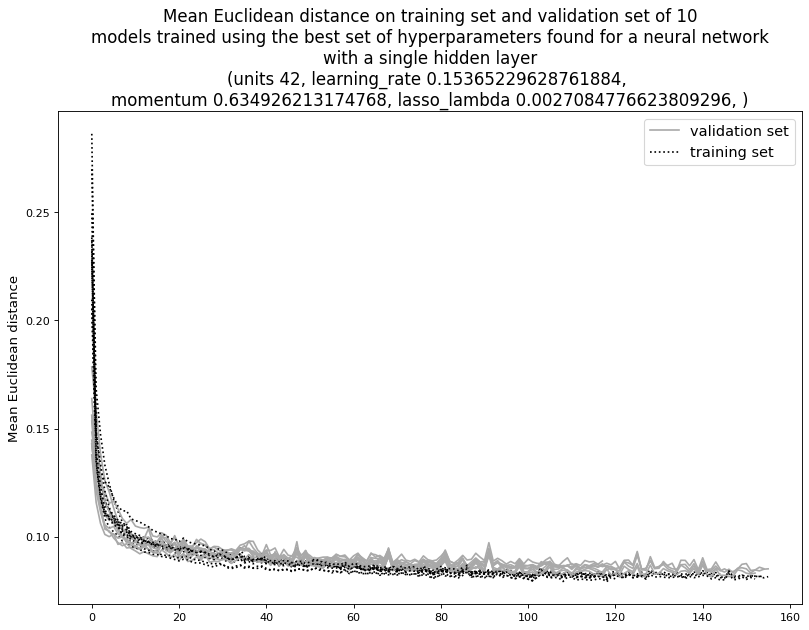

In [26]:
total_hp = 4
labels = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    labels += h_param + " " + str(best_hp2[0].get(h_param)) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']
    list_values_tr[i] = hist[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")", size=15
)

plt.ylabel("Mean Euclidean distance", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_single_layer.png")
plt.show()

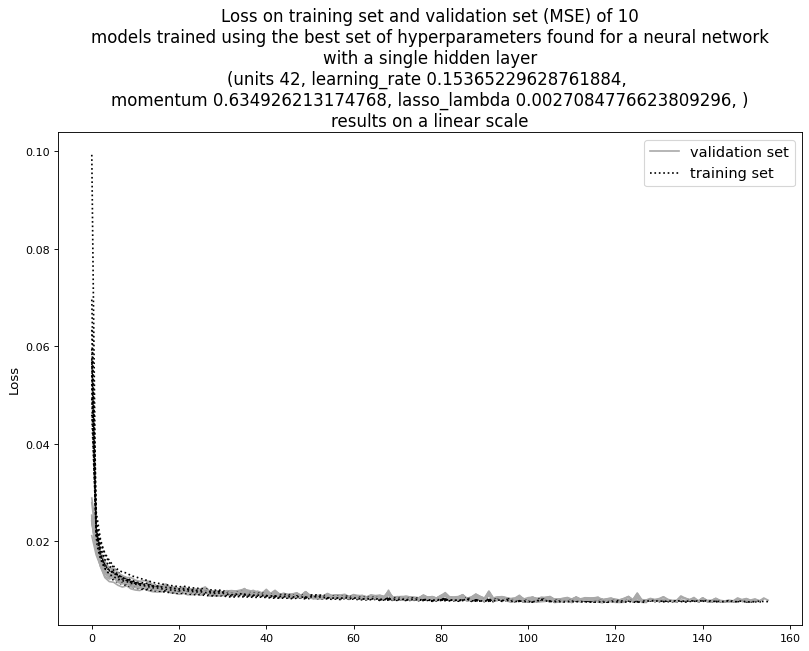

In [27]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist[i].history['val_loss']
    list_values2_tr[i] = hist[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer.png")
plt.show()

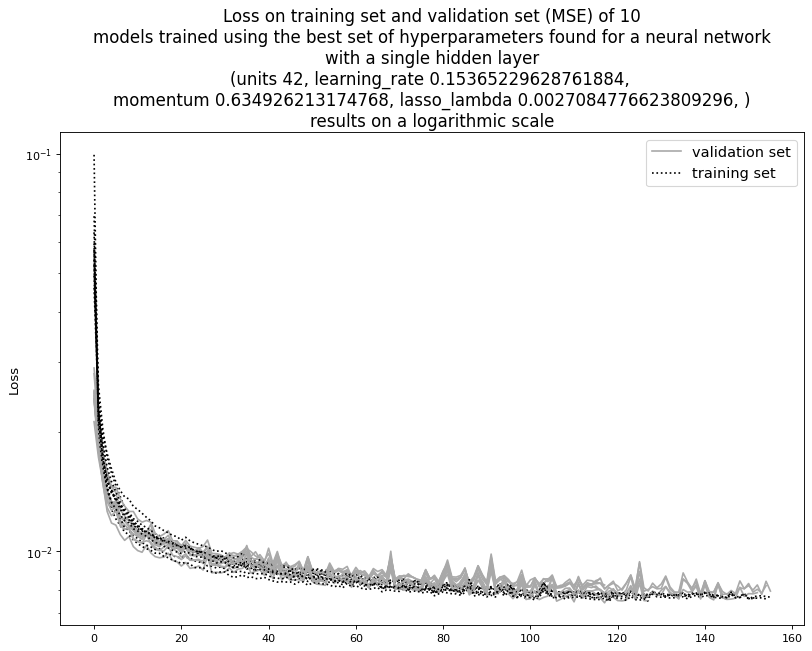

In [28]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set (MSE) of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with a single hidden layer\n("
    + labels + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_single_layer_log.png")
plt.yscale('log')
plt.show()

At this point we tried to add a second hidden layer to study whether its presence could help the neural network to generalise the problem.

Therefore we restarted the random search from scratch

In [29]:
# Restore the original training set
x_mlcup_tr = x_mlcup_ds
y_mlcup_tr = y_mlcup_ds

num_units_min = 30
num_units_max = 50
double_layer = True


# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, min_units=num_units_min,
    max_units=num_units_max, double_layer=double_layer
)


tuner3 = CrossValidationRandomSearch(
    hypermodel=br_l, # function that return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # number of models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/first/par_hp",
    folds_number=3 # number of folds of the cross validation
)

print a brief description of the search space

In [30]:
tuner3.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 30, 'max_value': 50, 'step': 3, 'sampling': None}
lasso_lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
learning_rate (Float)
{'default': 0.05, 'conditions': [], 'min_value': 0.05, 'max_value': 0.15, 'step': None, 'sampling': 'log'}
momentum (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': None, 'sampling': 'linear'}


In [31]:
tuner3.search(
    # the training set for the model selection
    x_mlcup_tr, y_mlcup_tr,
    # maximum number of epochs allowed
    epochs=2500,
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True,
)

Trial 50 Complete [00h 02m 28s]
val_euclidean_distance: 0.0824925775329272

Best val_euclidean_distance So Far: 0.07972562313079834
Total elapsed time: 01h 07m 08s
INFO:tensorflow:Oracle triggered exit


In [32]:
best_hp3 = tuner3.get_best_hyperparameters(3)

print("results of the first random search with a double hidden layer\n")
for i in range(len(best_hp3)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp3[i].get(h_param))
    print("")

results of the first random search with a double hidden layer

best hyperparameters n. 0
units 42
lasso_lambda 0.0006778891954121294
learning_rate 0.07052738876035652
momentum 0.7224878808278733

best hyperparameters n. 1
units 45
lasso_lambda 0.0004732110420851119
learning_rate 0.1045153154878995
momentum 0.5009581383853434

best hyperparameters n. 2
units 33
lasso_lambda 0.0004185367958047369
learning_rate 0.07429119762859726
momentum 0.7289125505649795



Brief description of the final neural network's structure

In [33]:
br_l = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model3 = br_l(best_hp3[0])
f_model3.build(
input_shape=(None, 9))

f_model3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 42)                420       
                                                                 
 dense_4 (Dense)             (None, 42)                1806      
                                                                 
 dense_5 (Dense)             (None, 2)                 86        
                                                                 
Total params: 2,312
Trainable params: 2,312
Non-trainable params: 0
_________________________________________________________________


In [34]:
tuner3.results_summary()

Results summary
Results in results/ml_cup/nn_RandomSearch/double_layer/first/par_hp
Showing 10 best trials
Trial summary
Hyperparameters:
units: 42
lasso_lambda: 0.0006778891954121294
learning_rate: 0.07052738876035652
momentum: 0.7224878808278733
Score: 0.07972562313079834
Trial summary
Hyperparameters:
units: 45
lasso_lambda: 0.0004732110420851119
learning_rate: 0.1045153154878995
momentum: 0.5009581383853434
Score: 0.07979908461372058
Trial summary
Hyperparameters:
units: 33
lasso_lambda: 0.0004185367958047369
learning_rate: 0.07429119762859726
momentum: 0.7289125505649795
Score: 0.08016349126895268
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.000719919051883511
learning_rate: 0.08795411406959326
momentum: 0.5802844294407086
Score: 0.08018157879511516
Trial summary
Hyperparameters:
units: 48
lasso_lambda: 0.00016312670104952942
learning_rate: 0.11701496480195064
momentum: 0.7212330459119989
Score: 0.08018722633520763
Trial summary
Hyperparameters:
units: 33
lasso_lambda:

Again, by now we have found a first best set of hyperparameters. We want to refine them by performing a second nested random search around this best combination of hyperparameters.

In [35]:
h_param = ["units", "lasso_lambda", "learning_rate", "momentum"]

num_units = best_hp3[0].get(h_param[0])
lasso_lambda = best_hp3[0].get(h_param[1])
learning_rate = best_hp3[0].get(h_param[2])
momentum = best_hp3[0].get(h_param[3])
double_layer = True

lasso_lambda_min = (lasso_lambda / 10) * 8
lasso_lambda_max = (lasso_lambda / 10) * 12

learning_rate_min = (learning_rate / 10) * 8
learning_rate_max = (learning_rate / 10) * 12

momentum_min = (momentum / 10) * 8
momentum_max = (momentum / 10) * 12

# This lambda function has been used to specify the space of the hyperparameters that we want to explore
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, 
    min_units=num_units, max_units=num_units, min_lasso_lambda=lasso_lambda_min,
    max_lasso_lambda=lasso_lambda_max, min_lr_rate=learning_rate_min,
    max_lr_rate=learning_rate_max,min_mom=momentum_min, max_mom=momentum_max, linear_lr=True,
    linear_reg=True, double_layer=double_layer
)

tuner4 = CrossValidationRandomSearch(
    hypermodel=br_l2, # function which return a model given a combination of hyperparameters
    objective=kt.Objective("val_euclidean_distance", direction="min"), # value to minimize
    max_trials=50, # maximum number of attempts
    executions_per_trial=2, # models created for each fold of the cross validation
    overwrite=True,
    directory="results/ml_cup",
    project_name="nn_RandomSearch/double_layer/nested/par_hp",
    folds_number=3,
    distribution_strategy=tf.distribute.MirroredStrategy()
)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Again, below there is a brief summary of the search space

In [36]:
tuner4.search_space_summary()

Search space summary
Default search space size: 4
units (Int)
{'default': None, 'conditions': [], 'min_value': 42, 'max_value': 42, 'step': 1, 'sampling': None}
lasso_lambda (Float)
{'default': 0.0005423113563297036, 'conditions': [], 'min_value': 0.0005423113563297036, 'max_value': 0.0008134670344945553, 'step': None, 'sampling': 'linear'}
learning_rate (Float)
{'default': 0.05642191100828522, 'conditions': [], 'min_value': 0.05642191100828522, 'max_value': 0.08463286651242782, 'step': None, 'sampling': 'linear'}
momentum (Float)
{'default': 0.5779903046622986, 'conditions': [], 'min_value': 0.5779903046622986, 'max_value': 0.8669854569934479, 'step': None, 'sampling': 'linear'}


In [37]:
tuner4.search(
    x_mlcup_tr, y_mlcup_tr, # training set for the random search 
    epochs=2500, # maximum number of epochs allowed
    # callback to implement early stopping
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)],
    shuffle=True
)

Trial 50 Complete [00h 02m 30s]
val_euclidean_distance: 0.08124580482641856

Best val_euclidean_distance So Far: 0.07846523821353912
Total elapsed time: 01h 52m 36s
INFO:tensorflow:Oracle triggered exit


Let's print again the best combination of hyperparameters found during this second nested random search with two hidden layers

In [38]:
best_hp4 = tuner4.get_best_hyperparameters(3)

print("results of the second nested random search with a single hidden layer\n")
for i in range(len(best_hp4)):
    print("best hyperparameters n.", i)
    for h_param in ["units", "lasso_lambda", "learning_rate", "momentum"]:
        print(h_param, best_hp4[i].get(h_param))
    print("")

results of the second nested random search with a single hidden layer

best hyperparameters n. 0
units 42
lasso_lambda 0.0007654254378632835
learning_rate 0.08327264158796636
momentum 0.794794115974796

best hyperparameters n. 1
units 42
lasso_lambda 0.0006272183707794795
learning_rate 0.06946983409463252
momentum 0.8281017922673055

best hyperparameters n. 2
units 42
lasso_lambda 0.0007678350209043903
learning_rate 0.08341630308766972
momentum 0.8414999842102251



Brief description of the final neural network's structure

In [39]:
br_l2 = lambda a: build_regressor(
    a, my_metric=euclidean_distance, double_layer=True
)

f_model4 = br_l2(best_hp4[0])
f_model4.build(
input_shape=(None, 9))

f_model4.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 42)                420       
                                                                 
 dense_4 (Dense)             (None, 42)                1806      
                                                                 
 dense_5 (Dense)             (None, 2)                 86        
                                                                 
Total params: 2,312
Trainable params: 2,312
Non-trainable params: 0
_________________________________________________________________


At this point we tried many neural networks using the best hyperparameters found by the second nested random search. Below we split the design set between training set and validation set. Remember that here we are using two hidden layers

In [40]:
subset_size = int(0.2 * len(x_mlcup_tr))

index = np.random.choice(len(x_mlcup_tr), subset_size, replace=False)
index = np.sort(index)

x_mlcup_ds = x_mlcup_tr
y_mlcup_ds = y_mlcup_tr

x_mlcup_vl = x_mlcup_ds[index]
y_mlcup_vl = y_mlcup_ds[index]

x_mlcup_tr = np.delete(x_mlcup_ds, index, 0)
y_mlcup_tr = np.delete(y_mlcup_ds, index, 0)

In [41]:
n_trials = 10

models2 = [None]*n_trials

for i in range(n_trials):
    models2[i] = br_l2(best_hp4[0])

n_epochs = 1000
hist2 = [None]*n_trials

for i in range(n_trials):
        hist2[i] = models2[i].fit(
            x=x_mlcup_tr,
            y=y_mlcup_tr,
            validation_data=(x_mlcup_vl, y_mlcup_vl),
            epochs=n_epochs,
            shuffle=True,
            callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss',  patience=10)]
        )

Epoch 1/1000
30/30 [==============================] - 1s 7ms/step - loss: 0.0539 - euclidean_distance: 0.2457 - val_loss: 0.0178 - val_euclidean_distance: 0.1368
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0167 - euclidean_distance: 0.1283 - val_loss: 0.0132 - val_euclidean_distance: 0.1084
Epoch 3/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0138 - euclidean_distance: 0.1116 - val_loss: 0.0122 - val_euclidean_distance: 0.1023
Epoch 4/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0127 - euclidean_distance: 0.1055 - val_loss: 0.0110 - val_euclidean_distance: 0.0949
Epoch 5/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0117 - euclidean_distance: 0.1008 - val_loss: 0.0100 - val_euclidean_distance: 0.0912
Epoch 6/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0109 - euclidean_distance: 0.0976 - val_loss: 0.0099 - val_euclidean_distance: 0.0927
Epoch 7/1000
30/30 [========

30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0805 - val_loss: 0.0072 - val_euclidean_distance: 0.0811
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0811 - val_loss: 0.0072 - val_euclidean_distance: 0.0826
Epoch 53/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0793 - val_loss: 0.0076 - val_euclidean_distance: 0.0841
Epoch 54/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0792 - val_loss: 0.0070 - val_euclidean_distance: 0.0799
Epoch 55/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0790 - val_loss: 0.0071 - val_euclidean_distance: 0.0816
Epoch 56/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0788 - val_loss: 0.0070 - val_euclidean_distance: 0.0804
Epoch 57/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0878 - val_loss: 0.0081 - val_euclidean_distance: 0.0842
Epoch 23/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0863 - val_loss: 0.0082 - val_euclidean_distance: 0.0861
Epoch 24/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0083 - euclidean_distance: 0.0871 - val_loss: 0.0081 - val_euclidean_distance: 0.0844
Epoch 25/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0869 - val_loss: 0.0080 - val_euclidean_distance: 0.0840
Epoch 26/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0886 - val_loss: 0.0081 - val_euclidean_distance: 0.0866
Epoch 27/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0861 - val_loss: 0.0080 - val_euclidean_distance: 0.0851
Epoch 28/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0783 - val_loss: 0.0076 - val_euclidean_distance: 0.0838
Epoch 73/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0797 - val_loss: 0.0068 - val_euclidean_distance: 0.0799
Epoch 74/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0793 - val_loss: 0.0075 - val_euclidean_distance: 0.0849
Epoch 75/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0791 - val_loss: 0.0070 - val_euclidean_distance: 0.0821
Epoch 76/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0788 - val_loss: 0.0068 - val_euclidean_distance: 0.0795
Epoch 77/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.0068 - euclidean_distance: 0.0807 - val_loss: 0.0068 - val_euclidean_distance: 0.0793
Epoch 1/1000
30/30 [================

30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0826 - val_loss: 0.0074 - val_euclidean_distance: 0.0819
Epoch 46/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0836 - val_loss: 0.0075 - val_euclidean_distance: 0.0822
Epoch 47/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0824 - val_loss: 0.0079 - val_euclidean_distance: 0.0856
Epoch 48/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0840 - val_loss: 0.0075 - val_euclidean_distance: 0.0823
Epoch 49/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0838 - val_loss: 0.0074 - val_euclidean_distance: 0.0824
Epoch 50/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0811 - val_loss: 0.0080 - val_euclidean_distance: 0.0888
Epoch 51/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0091 - euclidean_distance: 0.0893 - val_loss: 0.0091 - val_euclidean_distance: 0.0892
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.0886 - val_loss: 0.0085 - val_euclidean_distance: 0.0835
Epoch 18/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0089 - euclidean_distance: 0.0891 - val_loss: 0.0086 - val_euclidean_distance: 0.0866
Epoch 19/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0088 - euclidean_distance: 0.0883 - val_loss: 0.0083 - val_euclidean_distance: 0.0838
Epoch 20/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0088 - euclidean_distance: 0.0890 - val_loss: 0.0082 - val_euclidean_distance: 0.0833
Epoch 21/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0864 - val_loss: 0.0085 - val_euclidean_distance: 0.0886
Epoch 22/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0811 - val_loss: 0.0069 - val_euclidean_distance: 0.0795
Epoch 67/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0794 - val_loss: 0.0071 - val_euclidean_distance: 0.0804
Epoch 68/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0792 - val_loss: 0.0069 - val_euclidean_distance: 0.0789
Epoch 69/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0808 - val_loss: 0.0069 - val_euclidean_distance: 0.0787
Epoch 70/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0786 - val_loss: 0.0071 - val_euclidean_distance: 0.0801
Epoch 71/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0788 - val_loss: 0.0073 - val_euclidean_distance: 0.0817
Epoch 72/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0883 - val_loss: 0.0074 - val_euclidean_distance: 0.0818
Epoch 27/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0846 - val_loss: 0.0074 - val_euclidean_distance: 0.0819
Epoch 28/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0843 - val_loss: 0.0074 - val_euclidean_distance: 0.0822
Epoch 29/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0837 - val_loss: 0.0073 - val_euclidean_distance: 0.0811
Epoch 30/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0824 - val_loss: 0.0076 - val_euclidean_distance: 0.0848
Epoch 31/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0840 - val_loss: 0.0074 - val_euclidean_distance: 0.0821
Epoch 32/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0790 - val_loss: 0.0066 - val_euclidean_distance: 0.0777
Epoch 77/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0794 - val_loss: 0.0067 - val_euclidean_distance: 0.0780
Epoch 78/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0795 - val_loss: 0.0069 - val_euclidean_distance: 0.0799
Epoch 79/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0802 - val_loss: 0.0074 - val_euclidean_distance: 0.0863
Epoch 1/1000
30/30 [==============================] - 1s 7ms/step - loss: 0.0430 - euclidean_distance: 0.2229 - val_loss: 0.0211 - val_euclidean_distance: 0.1561
Epoch 2/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0194 - euclidean_distance: 0.1380 - val_loss: 0.0152 - val_euclidean_distance: 0.1171
Epoch 3/1000
30/30 [==================

30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0817 - val_loss: 0.0081 - val_euclidean_distance: 0.0844
Epoch 48/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0831 - val_loss: 0.0075 - val_euclidean_distance: 0.0791
Epoch 49/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0830 - val_loss: 0.0076 - val_euclidean_distance: 0.0816
Epoch 50/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0801 - val_loss: 0.0081 - val_euclidean_distance: 0.0867
Epoch 51/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0076 - euclidean_distance: 0.0822 - val_loss: 0.0075 - val_euclidean_distance: 0.0803
Epoch 52/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0822 - val_loss: 0.0077 - val_euclidean_distance: 0.0808
Epoch 53/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0789 - val_loss: 0.0068 - val_euclidean_distance: 0.0771
Epoch 98/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0774 - val_loss: 0.0067 - val_euclidean_distance: 0.0758
Epoch 99/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0764 - val_loss: 0.0070 - val_euclidean_distance: 0.0773
Epoch 100/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0778 - val_loss: 0.0068 - val_euclidean_distance: 0.0768
Epoch 101/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0065 - euclidean_distance: 0.0762 - val_loss: 0.0067 - val_euclidean_distance: 0.0769
Epoch 102/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0064 - euclidean_distance: 0.0757 - val_loss: 0.0070 - val_euclidean_distance: 0.0804
Epoch 103/1000
30/30 [===========

30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0857 - val_loss: 0.0078 - val_euclidean_distance: 0.0872
Epoch 40/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0841 - val_loss: 0.0081 - val_euclidean_distance: 0.0904
Epoch 41/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0868 - val_loss: 0.0076 - val_euclidean_distance: 0.0829
Epoch 42/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0074 - euclidean_distance: 0.0834 - val_loss: 0.0074 - val_euclidean_distance: 0.0831
Epoch 43/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0837 - val_loss: 0.0076 - val_euclidean_distance: 0.0844
Epoch 44/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0075 - euclidean_distance: 0.0844 - val_loss: 0.0073 - val_euclidean_distance: 0.0823
Epoch 45/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0104 - euclidean_distance: 0.0981 - val_loss: 0.0094 - val_euclidean_distance: 0.0910
Epoch 11/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0101 - euclidean_distance: 0.0971 - val_loss: 0.0095 - val_euclidean_distance: 0.0920
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0100 - euclidean_distance: 0.0964 - val_loss: 0.0092 - val_euclidean_distance: 0.0900
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0098 - euclidean_distance: 0.0958 - val_loss: 0.0091 - val_euclidean_distance: 0.0897
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0946 - val_loss: 0.0090 - val_euclidean_distance: 0.0900
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0096 - euclidean_distance: 0.0957 - val_loss: 0.0091 - val_euclidean_distance: 0.0904
Epoch 16/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0812 - val_loss: 0.0072 - val_euclidean_distance: 0.0802
Epoch 61/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0813 - val_loss: 0.0071 - val_euclidean_distance: 0.0791
Epoch 62/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0821 - val_loss: 0.0072 - val_euclidean_distance: 0.0808
Epoch 63/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0071 - euclidean_distance: 0.0807 - val_loss: 0.0070 - val_euclidean_distance: 0.0790
Epoch 64/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0073 - euclidean_distance: 0.0828 - val_loss: 0.0071 - val_euclidean_distance: 0.0800
Epoch 65/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0072 - euclidean_distance: 0.0820 - val_loss: 0.0073 - val_euclidean_distance: 0.0816
Epoch 66/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0857 - val_loss: 0.0083 - val_euclidean_distance: 0.0883
Epoch 32/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0080 - euclidean_distance: 0.0855 - val_loss: 0.0079 - val_euclidean_distance: 0.0851
Epoch 33/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0850 - val_loss: 0.0079 - val_euclidean_distance: 0.0850
Epoch 34/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0078 - euclidean_distance: 0.0847 - val_loss: 0.0078 - val_euclidean_distance: 0.0845
Epoch 35/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0077 - euclidean_distance: 0.0835 - val_loss: 0.0081 - val_euclidean_distance: 0.0877
Epoch 36/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0079 - euclidean_distance: 0.0857 - val_loss: 0.0079 - val_euclidean_distance: 0.0854
Epoch 37/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0791 - val_loss: 0.0077 - val_euclidean_distance: 0.0850
Epoch 82/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0782 - val_loss: 0.0071 - val_euclidean_distance: 0.0808
Epoch 83/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0070 - euclidean_distance: 0.0809 - val_loss: 0.0086 - val_euclidean_distance: 0.0929
Epoch 84/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0802 - val_loss: 0.0076 - val_euclidean_distance: 0.0844
Epoch 85/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0796 - val_loss: 0.0083 - val_euclidean_distance: 0.0915
Epoch 86/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0069 - euclidean_distance: 0.0800 - val_loss: 0.0072 - val_euclidean_distance: 0.0801
Epoch 87/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0085 - euclidean_distance: 0.0873 - val_loss: 0.0081 - val_euclidean_distance: 0.0850
Epoch 25/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0084 - euclidean_distance: 0.0868 - val_loss: 0.0080 - val_euclidean_distance: 0.0837
Epoch 26/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0087 - euclidean_distance: 0.0894 - val_loss: 0.0080 - val_euclidean_distance: 0.0850
Epoch 27/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0082 - euclidean_distance: 0.0862 - val_loss: 0.0079 - val_euclidean_distance: 0.0837
Epoch 28/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0853 - val_loss: 0.0078 - val_euclidean_distance: 0.0840
Epoch 29/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0081 - euclidean_distance: 0.0850 - val_loss: 0.0078 - val_euclidean_distance: 0.0831
Epoch 30/1000
30/30 [===============

30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0799 - val_loss: 0.0078 - val_euclidean_distance: 0.0868
Epoch 75/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0784 - val_loss: 0.0070 - val_euclidean_distance: 0.0814
Epoch 76/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0066 - euclidean_distance: 0.0792 - val_loss: 0.0069 - val_euclidean_distance: 0.0794
Epoch 77/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0800 - val_loss: 0.0069 - val_euclidean_distance: 0.0792
Epoch 78/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0068 - euclidean_distance: 0.0805 - val_loss: 0.0070 - val_euclidean_distance: 0.0819
Epoch 79/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.0067 - euclidean_distance: 0.0799 - val_loss: 0.0075 - val_euclidean_distance: 0.0872
Epoch 80/1000
30/30 [===============

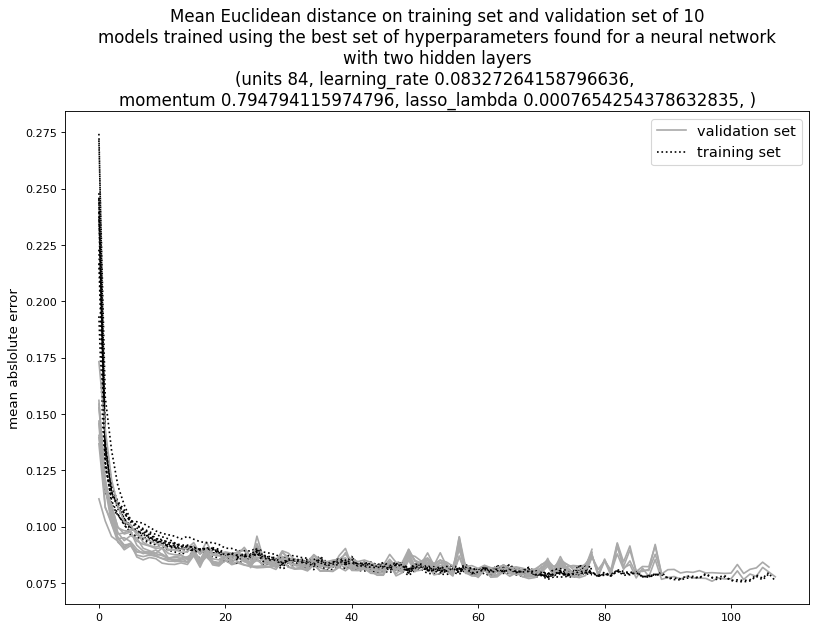

In [42]:
total_hp = 4
labels2 = ""
count = 1
for h_param in ["units", "learning_rate", "momentum", "lasso_lambda"]:
    hp_str = best_hp4[0].get(h_param)
    if (h_param == 'units'):
        hp_str *= 2
    labels2 += h_param + " " + str(hp_str) + ", "
    if(count % 2 == 0 and count != total_hp):
        labels2 += "\n"
    count += 1

list_values_val = [None]*n_trials
list_values_tr = [None]*n_trials

colours = ["darkgray", "black"]
linestyles = ["solid", "dotted"]

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']
    list_values_tr[i] = hist2[i].history['euclidean_distance']
        
max_length = 0
for i in range(n_trials):
    if (max_length < len(list_values_tr[i])):
        max_length = len(list_values_tr[i])
        
time_ep = list(range(max_length))

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values_val[i])], list_values_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values_tr[i])], list_values_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

legend = ["validation set", "training set"]

plt.title(
    "Mean Euclidean distance on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")", size=15
)

plt.ylabel("mean abslolute error", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/med_double_layer.png")
plt.show()

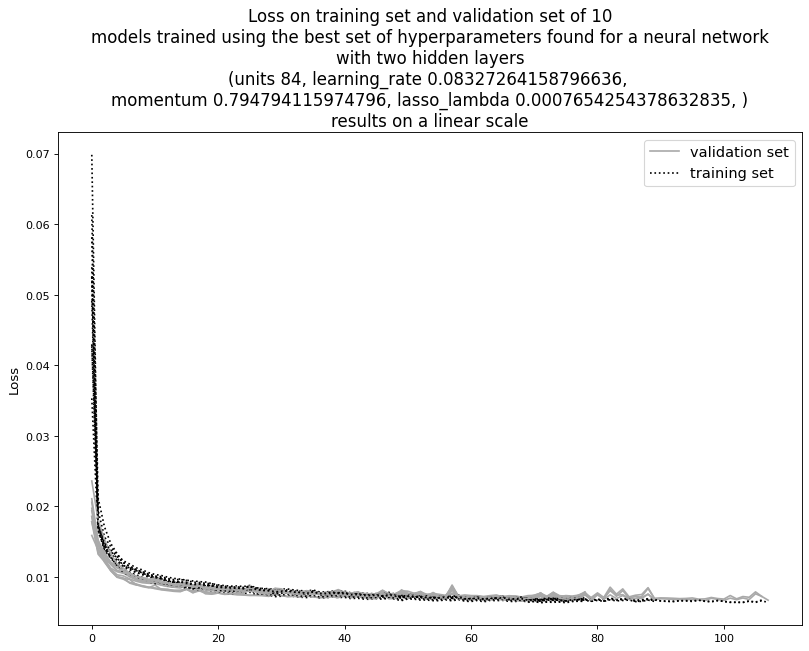

In [43]:
list_values2_val = [None]*n_trials
list_values2_tr = [None]*n_trials

for i in range(n_trials):
    list_values2_val[i] = hist2[i].history['val_loss']
    list_values2_tr[i] = hist2[i].history['loss']

plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a linear scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer.png")
plt.show()

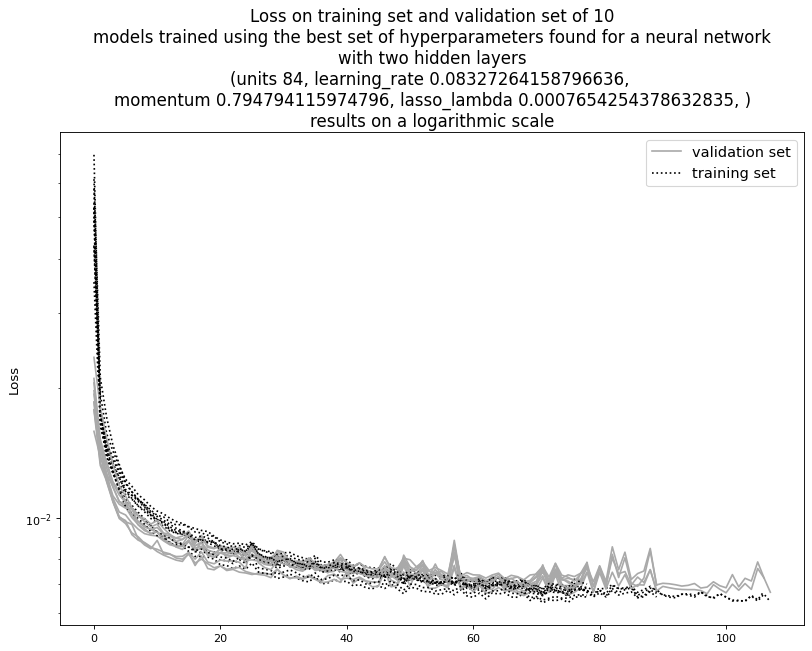

In [44]:
plt.figure(figsize=(12, 8), dpi=80)

for i in range(n_trials):
    plt.plot(
        time_ep[0:len(list_values2_val[i])], list_values2_val[i],
        color=colours[0], linestyle=linestyles[0]
    )
    plt.plot(
        time_ep[0:len(list_values2_tr[i])], list_values2_tr[i],
        color=colours[1], linestyle=linestyles[1]
    )

plt.title(
    "Loss on training set and validation set of " + str(n_trials) + "\n"
    "models trained using the best set of hyperparameters found for a neural network\n" +
    "with two hidden layers\n("
    + labels2 + ")\n" +
    "results on a logarithmic scale", size=15
)

plt.ylabel("Loss", size=12)
plt.legend(legend, prop={'size': 13})
plt.savefig("./plots/ml_cup/nn_RandomSearch/ms_loss_double_layer_log.png")
plt.yscale('log')
plt.show()

Let us know birefly compare the final scores reached by the models with two hidden layers and with just one

In [45]:
for i in range(n_trials):
    list_values_val[i] = hist[i].history['val_euclidean_distance']

print("Final score reached by the model with one hidden layer")
for i in range(10):
    a = list_values_val[i][len(list_values_val[i])-1]
    print("model", i, "final mean Euclidean error:", a)
    
predicted_target_ds = models2[0](x_mlcup_ds)


for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']

print("\nFinal score reached by the model with two hidden layers")
for i in range(10):
    a = list_values_val[i][len(list_values_val[i])-1]
    print("model", i, "final mean Euclidean error:", a)
    
predicted_target_ds = models2[0](x_mlcup_ds)

Final score reached by the model with one hidden layer
model 0 final mean Euclidean error: 0.0850125178694725
model 1 final mean Euclidean error: 0.08520802855491638
model 2 final mean Euclidean error: 0.08710893243551254
model 3 final mean Euclidean error: 0.08879002928733826
model 4 final mean Euclidean error: 0.08514036983251572
model 5 final mean Euclidean error: 0.08317692577838898
model 6 final mean Euclidean error: 0.08367986977100372
model 7 final mean Euclidean error: 0.08491020649671555
model 8 final mean Euclidean error: 0.08218491077423096
model 9 final mean Euclidean error: 0.09097907692193985

Final score reached by the model with two hidden layers
model 0 final mean Euclidean error: 0.0868152379989624
model 1 final mean Euclidean error: 0.07934103906154633
model 2 final mean Euclidean error: 0.08874422311782837
model 3 final mean Euclidean error: 0.07920926064252853
model 4 final mean Euclidean error: 0.0863044261932373
model 5 final mean Euclidean error: 0.0778018534183

Comparing the final scores reached by the models with one single hidden layer and with two, we found out that the models with two distinct hidden layers performed slightly better. For this reason we retrieved as final model, one among the neural network with two hidden layers. To avoid overfitting, we didn't choose the best model among those with two hidden layers, but the third one (out of 10).

In [55]:
# double hidden layer (retrieve the model with the median error)

rank = 3

for i in range(n_trials):
    list_values_val[i] = hist2[i].history['val_euclidean_distance']

final_values_val = [None]*n_trials
for i in range(n_trials):
    final_values_val[i] = list_values_val[i][len(list_values_val[i]) - 1]

list_scores = [None]*n_trials
for i in range(n_trials):
    list_scores[i] = [final_values_val[i], i]
    
list_scores = sorted(list_scores, key=itemgetter(0))

for i in range(n_trials):
    scr = list_scores[i][0]

index = list_scores[rank - 1][1]

avg_model_val_err = hist2[index].history['val_euclidean_distance']
list_length = len(avg_model_val_err)
final_val_err = avg_model_val_err[list_length - 1]


print(
    "\nThe validation error on the final model for NN with random search is "
      + str(final_val_err) + "\n"
)

avg_model_double = models2[index]
avg_model_double.save("results/ml_cup/nn_RandomSearch/avg_model_double_layer/")


The validation error on the final model for NN with random search is 0.07920926064252853

INFO:tensorflow:Assets written to: results/ml_cup/nn_RandomSearch/avg_model_double_layer/assets


In conclusion, we want to observe the generalization capabilities of our model with respect to the real targets

In [56]:
# predict the targets...

# ... for the whole design set
predicted_target_ds = avg_model_double.predict(x_mlcup_ds)
# ... for the training set 
predicted_target_tr = avg_model_double.predict(x_mlcup_tr)
# ... for the validation set
predicted_target_vl = avg_model_double.predict(x_mlcup_vl)

8/8 [==============================] - 0s 1ms/step


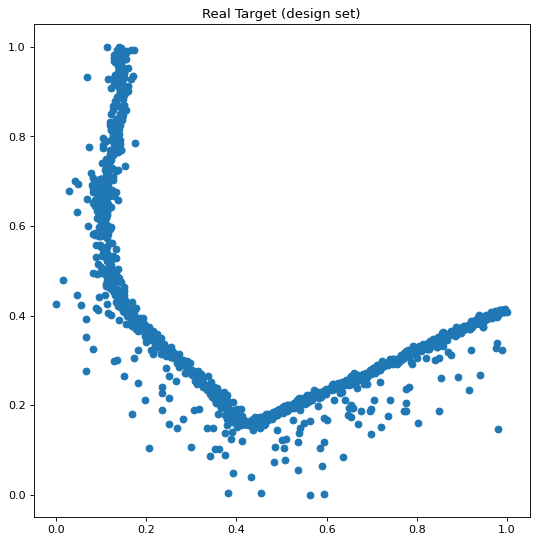

In [57]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1])
plt.title("Real Target (design set)")
plt.savefig("./plots/ml_cup/nn_RandomSearch/real_target.png")
plt.show()

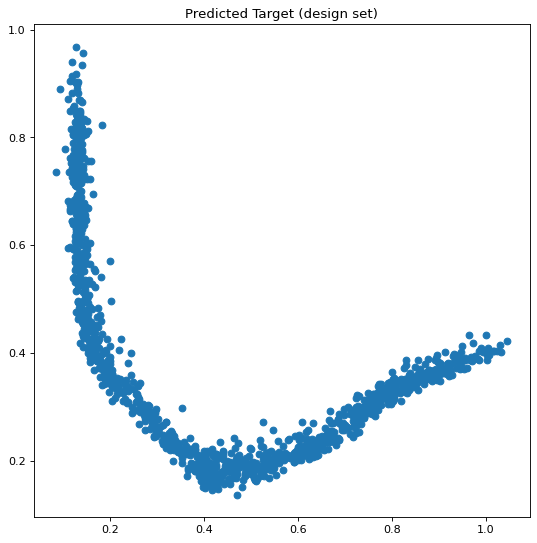

In [58]:
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_ds[:, 0], predicted_target_ds[:, 1])
plt.title("Predicted Target (design set)")
plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_target.png")
plt.show()

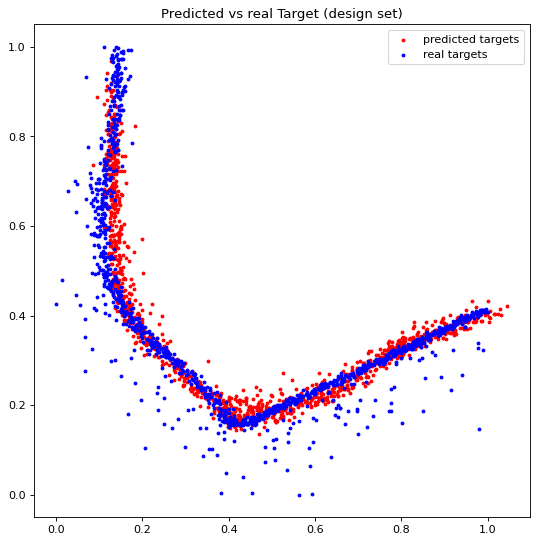

In [59]:
marker_size = 6
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_ds[:, 0], predicted_target_ds[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_ds[:, 0], y_mlcup_ds[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (design set)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.savefig("./plots/ml_cup/nn_RandomSearch/predicted_vs_real_target.png")
plt.show()


The very last step consists in denormalizing the predicted labels to study which is the final mean Euclidean distance with respect to the real ones. let's start by denormalizing our data

In [60]:
alrDenormalized = False

In [61]:
if (not alrDenormalized):
    # denormalize the training set (real and predicted targets)
    predicted_target_tr = deNormalizer(predicted_target_tr, max_col_value_y, min_col_value_y)
    y_mlcup_tr = deNormalizer(y_mlcup_tr, max_col_value_y, min_col_value_y)
    
    # denormalize the validation set (real and predicted targets)
    predicted_target_vl = deNormalizer(predicted_target_vl, max_col_value_y, min_col_value_y)
    y_mlcup_vl = deNormalizer(y_mlcup_vl, max_col_value_y, min_col_value_y)
    
    alrDenormalized = True

now we can compute the mean Euclidean error

In [62]:
res_tr = compute_mean_euclidean_error(y_mlcup_tr, predicted_target_tr)
res_vl = compute_mean_euclidean_error(y_mlcup_vl, predicted_target_vl)

print("Final mean Euclidean error on the training set: ", res_tr)
print("Final mean Euclidean error on the validation set: ", res_vl)

Final mean Euclidean error on the training set:  1.5274621518840321
Final mean Euclidean error on the validation set:  1.587093600439626


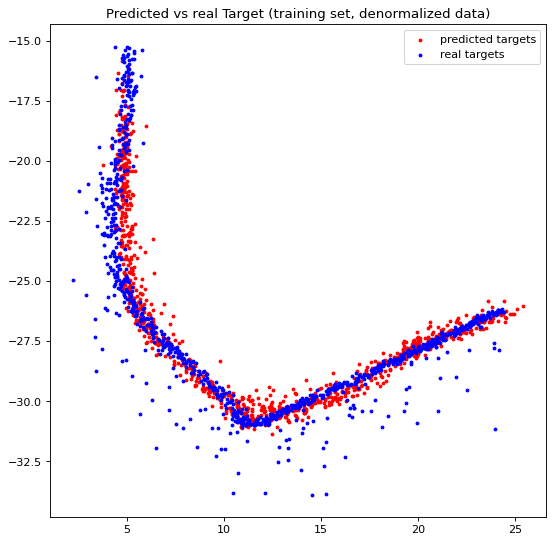

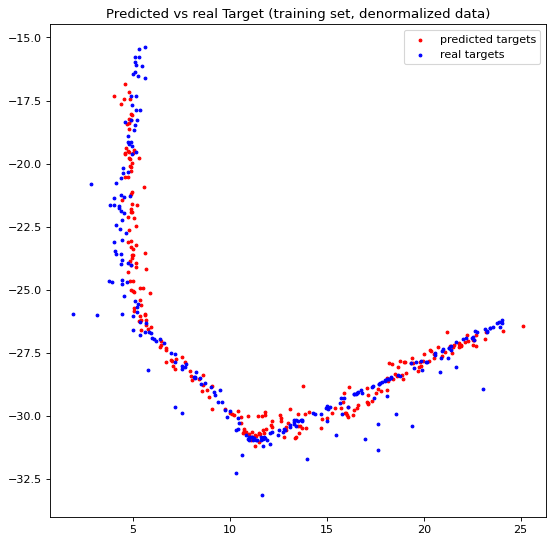

In [63]:
marker_size = 6

# plotting the results for the training set 

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_tr[:, 0], predicted_target_tr[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_tr[:, 0], y_mlcup_tr[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (training set, denormalized data)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

# plotting the results for the validation set 

plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(predicted_target_vl[:, 0], predicted_target_vl[:, 1], s=marker_size, c="red")
plt.scatter(y_mlcup_vl[:, 0], y_mlcup_vl[:, 1], s=marker_size, c="blue")
plt.title("Predicted vs real Target (training set, denormalized data)")

legend = ["predicted targets", "real targets"]
plt.legend(legend)

plt.show()